# Predicting Stock Market Movements with Random Forests
*By Evan Reynolds*

## 1. Introduction
&emsp; This report will investigate whether a random forest model can predict stock market movements and produce a strategy that is significantly better than a simple buy and hold strategy. The model will use simple technical predictors and macroeconomic data as inputs and attempt to predict whether or not the price of the S&P 500 will rise over the following week based on the inputs provided. An overview of the random forest algorithm will be provided, followed by a summary of the strategy and the predictors that will be used in the model. Next, the data will be setup and the model will be fitted using Python, and the strategy's performance will be computed. Finally, an evaluation of the portfolio's performance on an unseen dataset will be provided with accompanying performance analytics.

## 2. The Random Forest Algorithm

&emsp; Random forests is a relatively novel statistical and machine learning model that can be used to tackle both regression and classification problems. Prior to detailing the algorithm, a brief overview of Regression and Classification Trees must be provided, as they are the key component of a random forest. Going forward, we will focus on classification trees rather than regression trees as they are more applicable to our problem; however, the extension to regression trees is fairly straightforward.

&emsp; A classification tree is a model that can be used for calssification problems with two outcomes (they can be extended to problems with multiple outcomes, but in our case we will only be dealing with two outcomes). Explicitly, the classe, which are the possible values of the outcome variable $y$, are '0' for class 1 and '1' for class 2. When the tree is passed in a set of k features (predictors) in the form of a length k column vector $\vec{x_j}$, it will return a prediction $\hat{y_j}$, where $\hat{y_j} = 0$ if the predicted class of $y_j$ is class 1, and $\hat{y_j} = 1$ if the predicted class of $y_j$ is class 2. The model (tree) is constructed using a training data set $n$ of predictor and outcome values, $(\vec{x_i},y_i),i=1,...,n$. Below is an example of a classification tree:

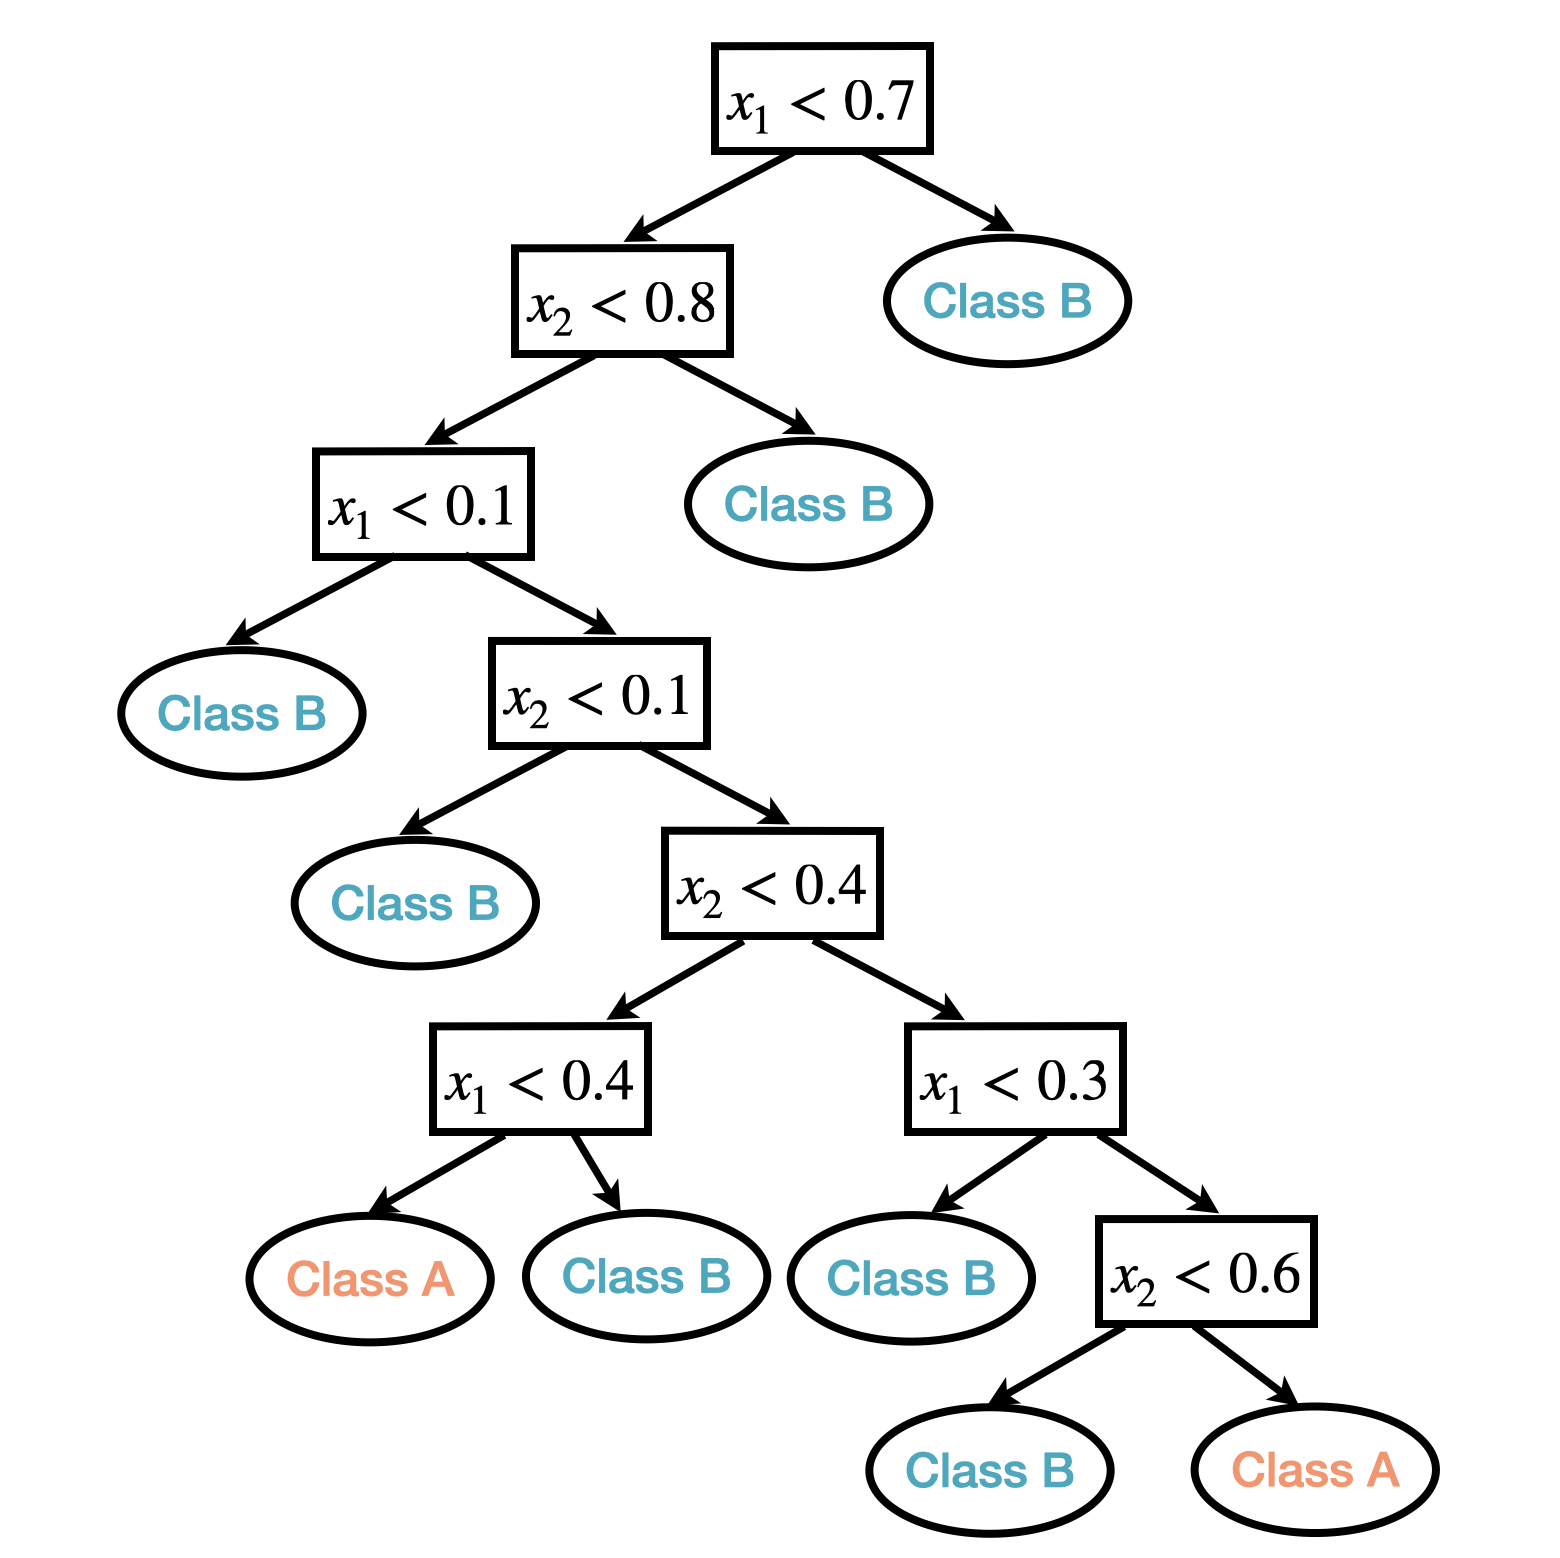

The tree's predictions are computed in the following manner: at each node (represented by the squares in the above image), a split is made based on an inequality for one of the k predictors - if the value of the variable in question for the vector $\vec{x_j}$ satisfies the inequality, it is passed to the left child node (a node below a given node is its 'child'), if not, it is passed to the right child node. The process continues from the new node at each step, until a leaf node (a node without any children) is reached. The leaf nodes contain classes, and the class in the leaf node that particular $\vec{x_j}$ reaches is the predicted outcome $\hat{y_j}$.

The tree is built from the top down based on the data set. All possible splits of the predictor values are considered, and the one that optimizes a certain criterion is chosen. A common criterion is the so called Gini impurity, which is calculated as

$$
1-\sum_{i=1}^{J} p_{i}^2
$$

for a given node, where $J$ is the number of distinct classes, and $p_i$ is the proportion of elements in the node belonging to class $i$. It quantifies the probability that a random item from a node would be mislabeled if it were randomly labeled according to the distribution of labels in its node. In our case, $J$ will be two since we will only be dealing with two classes. To evaluate a split, the Gini impurity for both the right and left child nodes is calculated and then a weighted average of the two is taken, weighted by the proportion of nodes in each child node. The split that minimizes the wighted average over all possible splits for any of the features is then selected. For example, in the tree above, the split $x_1 < 0.7$ was the split with the lowest weighted average of Gini impurities for the data, which is why it was chosen as the first split. The minimum value of the Gini impurity is 0 (which is attained when a node contains only one class), so once a node reaches an impurity of 0, it becomes a 'leaf' node and no further splitting from this node is considered. Whichever class of nodes live in the leaf node that $\vec{x_j}$ reaches when being passed down the tree represents the prediction $\hat{y_j}$ that would be given from that vector. When building a tree, it will be possible to continue to add splits until every leaf node is pure. However, to prevent model overfitting, sometimes splitting is stopped when

- a maximum threshold of possible splits is reached (i.e., a 'branch' reaches a maximum depth).
- a minimum number of observations is left in the leaf node.

These are so called 'hyperparameters' of a classification tree, and are set by the user beforehand. We will discuss these further shortly.

&emsp; One advatage of a classification tree in comparison to a logistic regression model for classification is its flexibility; it makes no assunmptions on the relationships between the outcome variable and its features. They also require little to no data preparation Unfortunately, classification trees are very prone to overfitting and in general their predictions do not provide satisfactory results, even when the hyperparameters above are tuned. This is the issue that random forests seek to mitigate against. Intead of constructing a single classification tree for our data, we will construct many to create a 'forest' of trees. For each constructed tree, two elements of randomization are built into its construction:

1. A bagged dataset (a sample with replacement of the original data set) is selected for its construction
2. At each node split, a random subset of the features will be taken and the best split of this subset of features wil be selected as the criteria to split the parent node into two leaf nodes.

The number of features in the subset selected for each split is usually taken as the root of the total number of features as a rule of thumb. (The log of the number of features is also commonly used). The number of trees in the forest is typically selected via a grid search, along with the maximum depth and minimum number of observations in a leaf node. To make a predict a class for $\vec{x_j}$, we will pass the vector into every tree in the forest, and the majority vote for the class from all of the trees will be the predicted class $\hat{y_j}$ (e.g., if we have 25 trees in the forest, and at least 13 predict that $\hat{y_j}$ comes from class 1 (i.e. $\hat{y_j} = 0$), then the overall prediction for $\hat{y_j}$ is class 1.

&emsp; Random forests can be easily implemented in Python using the SKLearn package. Now that an overview of the algorithm has been covered, we will discuss the application to predicting the daily price movements of the S&P 500.

## 3. Summary of Trading Strategy (Application of the RF model)

&emsp; The goal of our model will be to predict whether or not the S&P 500 will be higher at the close of the following day (specifically, the ETF SPY which tracks its performance and is easily tradeable). Class 1 will be that SPY fell in value, while class 2 will be that SPY rose in value (coinciding with $\hat{y_j} = 0$ and $\hat{y_j} = 1$ resepectively). Our list of features will include some very simple price movement and trading characteristics of the index:
- $x_1$: The daily percentage gain of the index on the current day.
- $x_2$: The weekly (5-day) percentage gain of the index on the current day.
- $x_3$: An indicator of whether the weekly trailing average price is greater than the 10-day trailing average.
- $x_4$: An indicator of whether the 10-day trailing average price is greater than the 21-day trailing average.
- $x_5$: The relative volume traded, calculated as a 5-day trailing average of the volume divided by the 63-day trailing average of the volume traded.
All of the above data can be computed easily using the historical data for SPY available on yahoo finance. We will also include several macroeconomic variables:
- $x_6$: The daily effective federal funds rate.
- $x_7$: The daily 5-year breakeven inflation rate.

Both of the macroeconomic datasets are available on the Federal Reserve Bank of St Louis (FRED) website.

&emsp; The actual trading strategy will be simple - if our RF model predicts that SPY will increase the following day, we will purchase SPY (or stay long if was already being held), and vice-versa if the model predicts it will decrease. However; rather than holding a portfolio of only SPY when the model predicts an up day and holding nothing when the model predicts a down day, the portfolio will swap between a portfolio of only SPY and weighted portfolio of SPY and TLT (the 20+ year Treasury Bill index etf). The reasoning to hold a portion of the portfolio in TLT is because its returns are negatively correlated to those of SPY (see below for correlation figures between the two), and therefore holding it could take advantage of market downturns. Several different weights (100/0, 80/20, and 60/40) will be evaluated.

## 4. Model Building and Portfolio Construction
### a. Data Preparation
&emsp; To begin, we will load in csv files for the relevant data sets needed using pandas. Data will be cleaned so that it can be processed by the model.

In [1]:
import pandas as pd
import os

#change working directory
os.chdir('RF Model Data')

In [2]:
import numpy as np

#import S&P data
df = pd.read_csv('SPY.csv')

#delete unneeded columns
df.drop(['Open','High','Low','Adj Close'],axis=1,inplace=True)

#calculate daily and weekly returns
df['Daily Returns'] = np.log(df['Close']/df['Close'].shift(1))
df['Weekly Returns'] = np.log(df['Close']/df['Close'].shift(5))

#calculate trailing averages
df['5 Day Trailing Average'] = df['Close'].rolling(window=5).mean()
df['10 Day Trailing Average'] = df['Close'].rolling(window=10).mean()
df['21 Day Trailing Average'] = df['Close'].rolling(window=21).mean()

#calculate relative volume ratio
df['Relative Volume Ratio'] = df['Volume'].rolling(window=5).mean()/df['Volume'].rolling(window=63).mean()

In [3]:
#calculate indicators to compare trailing averages
df['5 Day TA above 10 Day'] = np.select([(df['5 Day Trailing Average']>=df['10 Day Trailing Average']),
                                        (df['5 Day Trailing Average']<df['10 Day Trailing Average'])],[1,0])
df['10 Day TA above 21 Day'] = np.select([(df['10 Day Trailing Average']>=df['21 Day Trailing Average']),
                                        (df['10 Day Trailing Average']<df['21 Day Trailing Average'])],[1,0])

In [4]:
#drop unneeded columns again
df.drop(['Volume','5 Day Trailing Average','10 Day Trailing Average','21 Day Trailing Average'],axis=1,inplace=True)

In [5]:
#import macroeconomic data
df_ffr = pd.read_csv('DFF.csv')
df_ffr.columns = ['Date','FEDFUNDS']
df_bir = pd.read_csv('T5YIE.csv')
df_bir.columns = ['Date','T5YIE']

#convert inflation df to numeric
df_bir.loc[df_bir['T5YIE']=='.','T5YIE'] = 0
df_bir['T5YIE'] = pd.to_numeric(df_bir['T5YIE'])

#add columns for monthly changes in values
df_ffr['30 Day Change in the Daily Federal Funds Rate'] = df_ffr['FEDFUNDS'].diff(periods=30)
df_bir['30 Day Change in the Daily Break Even Inflation Rate'] = df_bir['T5YIE'].diff(periods=30)

#delete unneeded columns
df_ffr.drop('FEDFUNDS',axis=1,inplace=True)
df_bir.drop('T5YIE',axis=1,inplace=True)

In [6]:
#attach macroeconmic data onto df, with dates matching
df = df.merge(df_ffr,how='left',on='Date')
df = df.merge(df_bir,how='left',on='Date')

In [7]:
#calculate outcome variable on if the price increased the next day
df['SPY Increase Next Day'] = np.select([(df['Daily Returns']>=0),
                                        (df['Daily Returns']<0)],[1,0])

df['SPY Increase Next Day'] = df['SPY Increase Next Day'].shift(-1)

In [8]:
#drop nan entries
df.dropna(inplace=True)

In [9]:
df

,Date,Close,Daily Returns,Weekly Returns,Relative Volume Ratio,5 Day TA above 10 Day,10 Day TA above 21 Day,30 Day Change in the Daily Federal Funds Rate,30 Day Change in the Daily Break Even Inflation Rate,SPY Increase Next Day
2530,2003-02-13,82.349998,0.003040,-0.025181,1.148532,0,0,0.04,0.26,1.0
2531,2003-02-14,84.150002,0.021623,0.008713,1.232874,0,0,0.00,0.34,1.0
2532,2003-02-18,85.629997,0.017435,0.019100,1.199325,0,0,0.15,0.35,0.0
2533,2003-02-19,85.180000,-0.005269,0.020759,1.125590,0,0,0.04,0.29,0.0
2534,2003-02-20,84.330002,-0.010029,0.026800,1.092354,1,0,-0.06,0.28,1.0
...,...,...,...,...,...,...,...,...,...,...
7634,2023-05-24,411.089996,-0.007271,-0.010020,0.982008,1,1,0.25,-0.15,1.0
7635,2023-05-25,414.649994,0.008623,-0.010985,0.971030,1,1,0.25,-0.17,1.0
7636,2023-05-26,420.019989,0.012868,0.003339,0.946572,1,1,0.25,-0.18,1.0
7637,2023-05-30,420.179993,0.000381,0.003314,0.976574,0,1,0.25,-0.21,0.0


&emsp; We now have a dataframe with all of the listed features as well as the outcome variable. We will refrain from deleting the Date and Close columns; while they are not features in our model, they will be used when evaluating the strategy.

### b. Model Fitting and Hyperparameter Tuning
&emsp; We now have the necessary data to fit a random forest classifier model on the dependent variable of whether or not the S&P increases the following day. The model will be implemented via the SKLearn package, which contains implementations for various machine learning techniques, as well as supplementary methods for visualization and model evaluation. We will begin by importing the necessary packages.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

&emsp; Before fitting our final random forest model, we must first determine which hyperparameters are the best for our data set. As stated earlier, the hyperparameters of interest are:
- The minimum number of elements in a leaf node, and
- The number of trees in the forest

We will neglect setting a maximum depth for the trees and instead lean on the minimum leaf populations to mitigate against overfitting. Additionally, the conventional value of $\sqrt{k}$, where k is the number of features (in our case $k=7$), will be used for the number of features selected at each split. We can justify neglecting the optimiztion of these hyperparameters by the reduction in computational intensity it provides us.

&emsp; To determine what combination of these two hyperparameters is best suited for our problem, we will use the brute force grid search method: we will try multiple combinations of the two parameters and see what yields the best results. We will need to split our data into a training setand testing set. We will use an 80%/20% split. With our 80% training set, we will perform the grid search. A common strategy when performing hyperparameter optimization is the so-called cross validation strategy. This strategy splits your training set into a p folds. For each hyperparameter combination, we fit models using p-1 folds as the training set, and the remaining fold as the test set. The results for each fold are then averaged to develop an accuracy score for the hyperparameter combination. The intuition is that testing the combination over multiple different data sets given by the different selection of the testing fold will yield more generalizable results.

&emsp; As our data is a time series, this form of validation is not applicable, as we only want our model to be looking at past information when attempting to predict the future (e.g. it would not be intuitive to train a model with 2013-2020 data to predict data from 2012). Instead, we will use the rolling cross validation approach, where models for each hyperparameter combination are built using prior data only, with the training set being expanded and the testing set being shifted at each iteration. The image below illustrates the process:

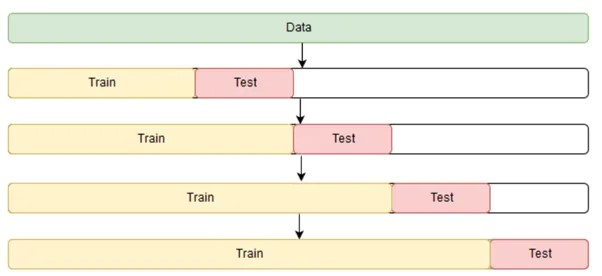

&emsp; Thankfully, the SKLearn package has modules specifically designed to run this form of cross validation. We will split our data into 4 folds for this process. The below code will return the optimal combination of hyperparameters that we provide (determined by their mean accuracy for predicting each test set).

In [11]:
#split data into dependent and independent variables
X = df.drop(['Date','Close','SPY Increase Next Day'],axis=1)
y=df['SPY Increase Next Day']

#split into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

#create hyperparameter vectors and parameter dict
min_leaf = [int(i) for i in np.linspace(1,51,11)]
n_trees = [int(i) for i in np.linspace(100,1000,10)]
param_search = {'n_estimators':n_trees,
             'min_samples_leaf':min_leaf}

#create time series CV split
tcsv = TimeSeriesSplit(n_splits=4)

#evaluate combinations of hyperparameters
model = RandomForestClassifier(random_state=42)
gSearch = GridSearchCV(estimator=model,cv=tcsv,param_grid=param_search)

#fit data to grid search
gSearch.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_leaf': [1, 6, 11, 16, 21, 26, 31, 36, 41,
                                              46, 51],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]})

In [12]:
#display optimal parameter values based on TSCV
print('The optimal hyperparameter choices were: ')
print(gSearch.best_params_)
print('Which obtained a mean score of: '+str(gSearch.best_score_*100)+'%')

The optimal hyperparameter choices were: 
{'min_samples_leaf': 46, 'n_estimators': 100}
Which obtained a mean score of: 53.39657282741738%


&emsp; We now have a baseline for our optimal hyperparameter combination. Before continuing, we will conduct a final search for hyperparameter values close to the ones chosen in the previous step to see if it's possible to make a slight improvement.

In [21]:
#conduct some final, localized searching around this pseudo optimized parameters
loc_min_leaf = [i for i in range(max(gSearch.best_params_['min_samples_leaf']-4,0),gSearch.best_params_['min_samples_leaf']+5)]
loc_n_trees = [int(i) for i in np.linspace(gSearch.best_params_['n_estimators']-75,gSearch.best_params_['n_estimators']+75,7)]

loc_param_search = {'n_estimators':loc_n_trees,
                     'min_samples_leaf':loc_min_leaf}

gSearchLoc = GridSearchCV(estimator=model,cv=tcsv,param_grid=loc_param_search)
#evaluate more localized combinations of hyperparameters
gSearchLoc.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_leaf': [42, 43, 44, 45, 46, 47, 48, 49,
                                              50],
                         'n_estimators': [25, 50, 75, 100, 125, 150, 175]})

In [22]:
#print the maximum localized results
print('The optimal localized hyperparameter choices were: ')
print(gSearchLoc.best_params_)
print('Which obtained a mean score of: '+str(gSearchLoc.best_score_*100)+'%')

The optimal localized hyperparameter choices were: 
{'min_samples_leaf': 45, 'n_estimators': 25}
Which obtained a mean score of: 53.91676866585067%


&emsp; Since the optimal number of trees is at the lower endpoint of our grid, we will conduct a final search over some lesser values, using the same value for the minimum leaf populations.

In [23]:
loc_n_trees = gSearchLoc.best_params_['n_estimators']
fin_param_search = {'n_estimators':[int(i) for i in np.linspace(5,loc_n_trees,5)],
                    'min_samples_leaf':[gSearchLoc.best_params_['min_samples_leaf']]}

gSearchFin = GridSearchCV(estimator=model,cv=tcsv,param_grid=fin_param_search)
#evaluate more localized combinations of hyperparameters
gSearchFin.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'min_samples_leaf': [45],
                         'n_estimators': [5, 10, 15, 20, 25]})

In [24]:
print('The final optimized hyperparameter choices were: ')
print(gSearchFin.best_params_)
print('Which obtained a mean score of: '+str(gSearchFin.best_score_*100)+'%')

The final optimized hyperparameter choices were: 
{'min_samples_leaf': 45, 'n_estimators': 25}
Which obtained a mean score of: 53.91676866585067%


&emsp; This final search did not yield any improvements. We now have our optimized set of hyperparameters, listed above. We can save these optimal values into variables and then fit our final model on the full training set. After, we will evaluate the model based on its results with the testing set and present some additional model diagnostics.

In [25]:
#set optimal values
op_hp_vals = gSearchFin.best_params_

### c. Final Model Fitting, Evaluation and Diagnostics
&emsp; To begin this section, let us fit our final random forest model based on the optimal hyperparameter values found in the previous section. To reiterate, this model will be fitted based on the full training set (the first 80% of our data).

In [26]:
#fit final rf model
final_rf = RandomForestClassifier(n_estimators=op_hp_vals['n_estimators'],min_samples_leaf=op_hp_vals['min_samples_leaf'],random_state=42)
final_rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=45, n_estimators=25, random_state=42)

&emsp; To begin our diagnostics, we first can check the accuracy of our final model on the test set.

In [27]:
y_pred = final_rf.predict(X_test)
final_accuracy = accuracy_score(y_test,y_pred)
print("The final model's accuracy score is: "+str(final_accuracy*100)+"%")

The final model's accuracy score is: 53.8160469667319%


&emsp; Our model is predicting an increase in SPY at only a marginally better rate than 50%. We can also check the precision and recall scores of the predictions. The precision score is defined as the number of correct class 1 predictions as a percentage of all class 1 predictions. Recall is the number of correct class 1 predictions as a percentage of the number of correct class 1 predictions and incorrect class 0 predictions.

In [28]:
final_precision = precision_score(y_test,y_pred)
final_recall = recall_score(y_test,y_pred)

print("The final model's precision score is: "+str(final_precision*100)+"%")
print("The final model's recall score is: "+str(final_recall*100)+"%")

The final model's precision score is: 54.63182897862233%
The final model's recall score is: 83.63636363636363%


&emsp; To gain more information, we can look at the confusion matrix of the model, which displays the the classes of the predicted outcome values and the classes of the true outcome values in a two by two grid.

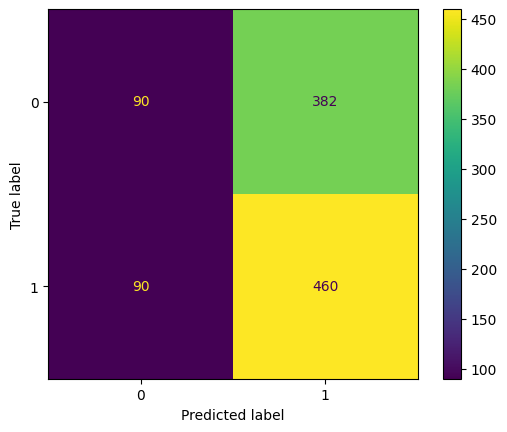

In [29]:
cm = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

&emsp; We can see that our model is fairly poor at predicting decreases in SPY - this is shown by the high number of increase predictions that were actually decreases.

&emsp; Next, we can check the feature importance of the model features. This is calculated as the average decrease in gini impurity that feature's splits yield (with the average being taken over all of the trees in the forest), weighted by an approximate probability of an element being a part of that split (which can be taken as the proportion of elements that are in that parent node being split). From a high level, splits that occur higher up on the tree and yield purer children nodes will be expected to have a higher feature importance. The values are standardized such that they sum to 1.

<Axes: >

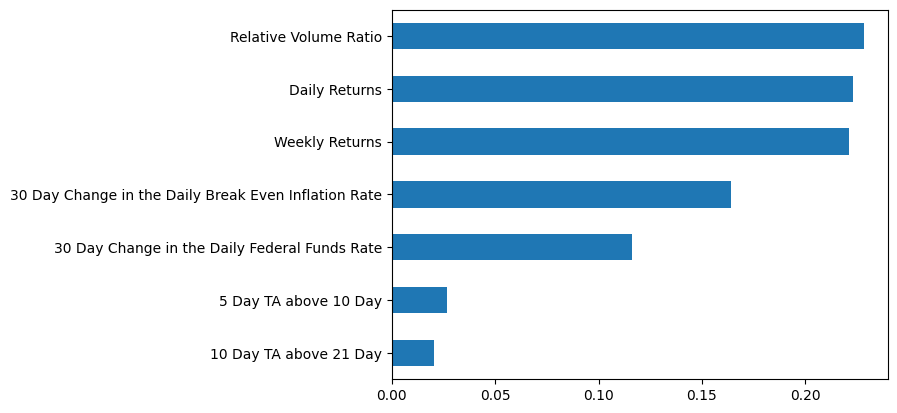

In [30]:
feature_importances = pd.Series(final_rf.feature_importances_,index=X_train.columns).sort_values()
feature_importances.plot.barh()

&emsp; Interestingly, the Relative Volume Ratio was our most important predictor, along with the Daily and Weekly Returns. Our macroeconomic indicators were of modest importance, while the importance of our trailing average indicators was negligible. It must be noted that the value and interpretation of these metrics are the subject of scrutiny and should not be treated as definitive evidence of variable relationships or the strength of those relationships.

&emsp; Now that we have fitted our final model and performed some analysis, we can move on to backtesting our trading strategy over the test set.

## 5. Backtesting Trading Strategy
### a. Computing Portfolio Balances

&emsp; Now that we have built our random forest model, we can simulate how a trading strategy that used the model would have performed. As stated above, our strategy will revolve around trading a portfolio that holds the S&P 500 (via SPY) and the 20-year US treasury index (via TLT). When our model predicts that SPY will increase the following day, we will weight SPY more heavily - and vice-versa when our model predicts that SPY will decrease. We will test out several different portolio weights: 100/0, 80/20, and 60/40. On consecutive days of predicted increases/decreases, no adjustments are required. We will test the strategy over the period that conincides with the test set of our model, which is the most recent 20% of our dataset. We will assume an initial portfolio size of \\$100,000, as well as a fee of \\$9.95 for each sale (which is the maximum fee for selling etfs on Questrade). We also assume fractional shares are available.

&emsp; We begin by importing daily TLT price data and setting up the backtesting dataframe.

In [31]:
#import TLT data
df_tlt = pd.read_csv('TLT.csv')
df_tlt = df_tlt[['Date','Close']]

#get the final rows of the dataframe that coincide with the testing set
df_backtest = df.tail(len(y_test))
#extract necessary columns
df_backtest = df_backtest[['Date','Close']]
#rename price column to SPY Close
df_backtest.rename(columns={"Close":"SPY Close"},inplace=True)
#rename price column on TLT data
df_tlt.rename(columns={"Close":"TLT Close"},inplace=True)

#join TLT data to frame
df_backtest = df_backtest.merge(df_tlt,how='left',on='Date')
#add y_pred column to dataframe
df_backtest['SPY Increase Predictions'] = y_pred

df_backtest

,Date,SPY Close,TLT Close,SPY Increase Predictions
0,2019-05-10,288.100006,124.750000,1.0
1,2019-05-13,280.859985,125.730003,1.0
2,2019-05-14,283.399994,125.360001,1.0
3,2019-05-15,285.059998,126.129997,1.0
4,2019-05-16,287.700012,125.709999,1.0
...,...,...,...,...
1017,2023-05-24,411.089996,100.529999,1.0
1018,2023-05-25,414.649994,100.279999,1.0
1019,2023-05-26,420.019989,101.089996,1.0
1020,2023-05-30,420.179993,102.099998,0.0


In [38]:
#add column for whether or not to shift the portfolio balance
df_backtest.loc[df_backtest['SPY Increase Predictions'] != df_backtest['SPY Increase Predictions'].shift(1),'Shift Portfolio'] = 1
df_backtest.loc[df_backtest['SPY Increase Predictions'] == df_backtest['SPY Increase Predictions'].shift(1),'Shift Portfolio'] = 0

#add column for trading fees
df_backtest.loc[:,'Portfolio Fees'] = 0.0
df_backtest.loc[df_backtest['Shift Portfolio'] == 1,'Portfolio Fees'] = 9.95
#remove fees from initial purchase since no shares are being sold
df_backtest.loc[0, 'Portfolio Fees'] = 0.0

df_backtest

,Date,SPY Close,TLT Close,SPY Increase Predictions,Shift Portfolio,Portfolio Fees
0,2019-05-10,288.100006,124.750000,1.0,1.0,0.00
1,2019-05-13,280.859985,125.730003,1.0,0.0,0.00
2,2019-05-14,283.399994,125.360001,1.0,0.0,0.00
3,2019-05-15,285.059998,126.129997,1.0,0.0,0.00
4,2019-05-16,287.700012,125.709999,1.0,0.0,0.00
...,...,...,...,...,...,...
1017,2023-05-24,411.089996,100.529999,1.0,0.0,0.00
1018,2023-05-25,414.649994,100.279999,1.0,0.0,0.00
1019,2023-05-26,420.019989,101.089996,1.0,0.0,0.00
1020,2023-05-30,420.179993,102.099998,0.0,1.0,9.95


&emsp; Now that we have added some helper columns and setup our dataframe, we can create a function that will calculate the value of our portfolio, with target weights and an initial size as inputs. This portfolio will then be applied iteratively to the dataframe to calculate the portfolio balance at each step. Although this is not the best practice with pandas, it will suffice in this case as our dataframe is only a little over 100 rows.

&emsp; We will place the portfolio balances for different target weights of our strategy into a separate dataframe for strategy evaluation, along with the performance of a reference portfolio which will be a simple buy and hold strategy on the S&P 500.

In [39]:
#create function to fill the number of shares, weights, and portfolio balance at each day
def pf_balance(row,weight,initial_size):#row is a row of df_backtest, weight is the targeted S&P weight, initial_size is the initial portfolio balance
    #first row
    try:
        last_row = df_backtest[df_backtest['Date']<row['Date']].iloc[-1]
    except IndexError:
        if row['SPY Increase Predictions'] == 1:
            return weight, 1-weight, initial_size*weight/row['SPY Close'], initial_size*(1-weight)/row['TLT Close'], initial_size
        else:
            return 1-weight, weight, initial_size*(1-weight)/row['SPY Close'], initial_size*weight/row['TLT Close'], initial_size
    
    #if we are at a trade row
    if row['Shift Portfolio'] == 1:
        pf_bal = last_row['SPY Shares']*row['SPY Close'] + last_row['TLT Shares']*row['TLT Close'] - row['Portfolio Fees']
        #if we are moving into an S&P heavy position
        if row['SPY Increase Predictions'] == 1:
            return weight, 1-weight, pf_bal*weight/row['SPY Close'], pf_bal*(1-weight)/row['TLT Close'], pf_bal
        else:#we are moving into a TLT heavy position
            return 1-weight, weight, pf_bal*(1-weight)/row['SPY Close'], pf_bal*weight/row['TLT Close'], pf_bal
    
    else:#we are not making a trade
        spy_bal = last_row['SPY Shares']*row['SPY Close']
        tlt_bal = last_row['TLT Shares']*row['TLT Close']
        pf_bal = spy_bal+tlt_bal
        return spy_bal/pf_bal, tlt_bal/pf_bal, last_row['SPY Shares'], last_row['TLT Shares'], pf_bal

In [41]:
#create portfolio balance dataframe
df_pfs = pd.DataFrame(df_backtest['Date'])
cols = [x+' Portfolio Balance' for x in ['100/0','80/20','60/40']]
weights = [1.0,0.8,0.6]

#apply function to add columns for portfolio balance for each weight target 
for i in range(0,len(weights)):
    df_backtest[['SPY Weight','TLT Weight','SPY Shares','TLT Shares','Portfolio Balance']] = 0.0
    for index, row in df_backtest.iterrows():
        df_backtest.loc[index,['SPY Weight','TLT Weight','SPY Shares','TLT Shares','Portfolio Balance']] = pf_balance(row,weights[i],100000.0)
    
    df_pfs[cols[i]] = df_backtest['Portfolio Balance']

In [42]:
#add column for benchmark balance
pd.set_option('display.float_format', '{:.2f}'.format)
df_pfs['Benchmark Portfolio Balance'] = (df_backtest['SPY Close']/df_backtest['SPY Close'].iloc[0])*100000

In [43]:
#print df
df_pfs

,Date,100/0 Portfolio Balance,80/20 Portfolio Balance,60/40 Portfolio Balance,Benchmark Portfolio Balance
0,2019-05-10,100000.00,100000.00,100000.00,100000.00
1,2019-05-13,97486.98,98146.70,98806.42,97486.98
2,2019-05-14,98368.62,98792.69,99216.76,98368.62
3,2019-05-15,98944.81,99377.09,99809.37,98944.81
4,2019-05-16,99861.16,100042.84,100224.51,99861.16
...,...,...,...,...,...
1017,2023-05-24,167226.94,141268.50,118303.37,142690.03
1018,2023-05-25,168675.11,142192.73,118820.48,143925.72
1019,2023-05-26,170859.57,143903.77,120138.01,145789.65
1020,2023-05-30,170914.71,144207.98,120613.71,145845.19


### b. Backtest Analysis

&emsp; Now that we have the balances for all of our portfolios as well as our benchmark, we can begin conducting some analysis on their performances over the backtesting period. To begin, let's simply construct a graph of the balances for each portfolio over the backtesting period.

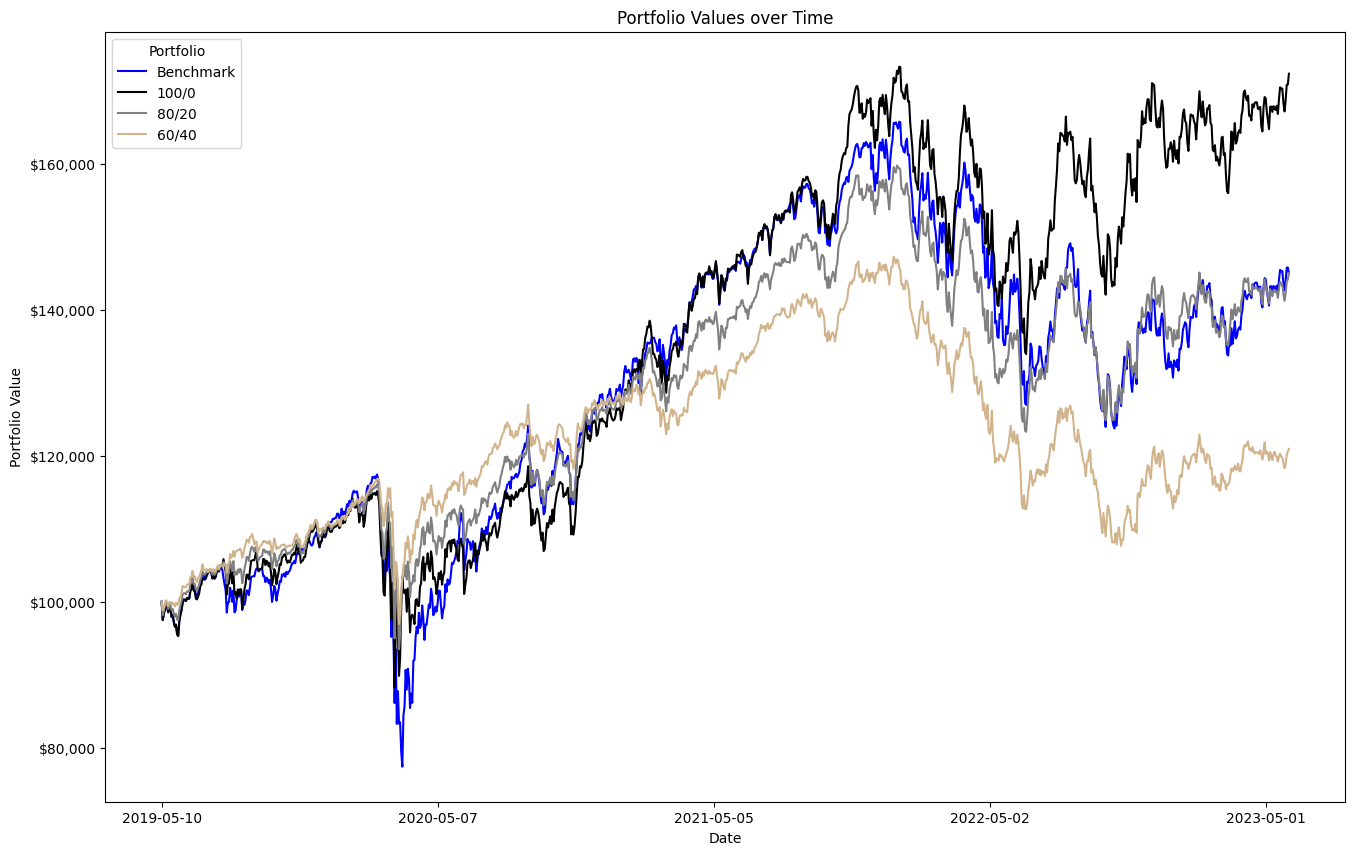

In [44]:
import matplotlib.pyplot as plt
#display graph for portfolio balances
x = df_pfs['Date']

fig,ax = plt.subplots(figsize=(16,10))

ax.plot(x,df_pfs['Benchmark Portfolio Balance'],color='blue')
ax.plot(x,df_pfs['100/0 Portfolio Balance'],color='black')
ax.plot(x,df_pfs['80/20 Portfolio Balance'],color='grey')
ax.plot(x,df_pfs['60/40 Portfolio Balance'],color='tan')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value')
ax.set_title('Portfolio Values over Time')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.legend(['Benchmark','100/0','80/20','60/40'],loc='upper left',title='Portfolio')
plt.show()

&emsp; At a first glance, we can see that our 100/0 portfolio, which shifts fully from SPY to TLT based on the model predictions, actually outperformed the benchmark portfolio. The 80/20 portfolio performed similarly, while the 60/40 portfolio underperformed. Given that SPY overall performed much better than TLT over the backtesting period, it is no surprise that the 100/0 portfolio outperformed the others - from our confusion matrix, we know that the model is predicting an increase in SPY much more often than a decrease, and therefore the portfolio would be holding SPY much more often than TLT. The fact that this portfolio did outperform the benchmark provides some level of validation that the model's predictions are valuable.

&emsp; Next, we can calculate the daily returns for each portfolio and then calculate statistics such as the Sharpe Ratio, Sortino Ratio, VaR, and Maximum Drawdown. Note that annualized metrics are computed on a log basis, while cumulative returns are computed on a simple 

In [50]:
from tabulate import tabulate

# Setup lists to assist with computing and printing metrics
col_prefix = [i + ' Portfolio' for i in ['100/0', '80/20', '60/40', 'Benchmark']]
return_cols = [i + ' Returns' for i in col_prefix]
balance_cols = [i + ' Balance' for i in col_prefix]

#calculate annualized returns and sd's
portfolio_cumulative_r = [(df_pfs[i].iloc[-1]-df_pfs[i].iloc[0])/df_pfs[i].iloc[0] for i in balance_cols]
portfolio_annualized_r = [252*df_pfs[i].mean() for i in return_cols]
portfolio_annualized_sd = [np.sqrt(252*df_pfs[i].var()) for i in return_cols]

#risk free rate as per https://www.multpl.com/5-year-treasury-rate/table/by-month
rf = 0.0219
#calculate sharpe ratios
portfolio_annualized_sharpe = [(i-rf)/j for (i,j) in zip(portfolio_annualized_r,portfolio_annualized_sd)]

#get z-quantile for VaR calculation
from scipy import stats
z_quant = stats.norm.ppf(0.05)
#calculate weekly 95% VaR
VaR = [5*df_pfs[i].mean()+z_quant*np.sqrt(5*df_pfs[i].var()) for i in return_cols]

#create new df for sortino ratio calc
sort_df = df_pfs[return_cols]
sort_df = sort_df.mask(sort_df>0,0)
sort_sd = [np.sqrt(252*sort_df[i].var()) for i in return_cols]
sort_ratio = [(i-rf)/j for (i,j) in zip(portfolio_annualized_r,sort_sd)]

#calculate max drawdown
max_drawdown = [min((df_pfs[i] - df_pfs[i].cummax())/df_pfs[i].cummax()) for i in balance_cols]

table = [['Metric'] + col_prefix,
         ['Cumulative Returns']+["{:.2%}".format(i) for i in portfolio_cumulative_r],
         ['Annualized Returns']+["{:.2%}".format(i) for i in portfolio_annualized_r],
         ['Sharpe Ratio']+["{:.3}".format(i) for i in portfolio_annualized_sharpe],
         ['Weekly 95% VaR']+["{:.2%}".format(i) for i in VaR],
         ['Sortino Ratio']+["{:.3}".format(i) for i in sort_ratio],
         ['Max Drawdown']+["{:.2%}".format(i) for i in max_drawdown]]


print(tabulate(table,headers='firstrow',tablefmt='pretty'))

+--------------------+-----------------+-----------------+-----------------+---------------------+
|       Metric       | 100/0 Portfolio | 80/20 Portfolio | 60/40 Portfolio | Benchmark Portfolio |
+--------------------+-----------------+-----------------+-----------------+---------------------+
| Cumulative Returns |     72.39%      |     45.04%      |     20.97%      |       45.04%        |
| Annualized Returns |     13.44%      |      9.18%      |      4.70%      |        9.18%        |
|    Sharpe Ratio    |      0.515      |      0.413      |      0.186      |        0.307        |
|   Weekly 95% VaR   |     -4.80%      |     -3.74%      |     -3.03%      |       -5.10%        |
|   Sortino Ratio    |      0.799      |      0.631      |      0.284      |        0.462        |
|    Max Drawdown    |     -23.35%     |     -22.84%     |     -26.91%     |       -34.10%       |
+--------------------+-----------------+-----------------+-----------------+---------------------+


&emsp; Analyzing the results, it's interesting how the returns illustrate just how much better the 100/0 portfolio performed than the benchmark, surpassing its annaulized returns by over 4%. The higher sharpe and sortino ratios, as well as the lesser weekly value at risk and maximum drawdown suggests that it did so while taking on a lower degree of risk. Shockingly, the 80/20 portfolio performed the exact same as the benchmark portfolio in terms of returns; however, it had more desireable risk measures over the backtesting period. It also had the lowest maximum drawdown and a significantly better weekly VaR than the 100/0 portfolio. The 60/40 portfolio underperformed the field by almost all metrics.

## 6. Conclusion and Limitations

&emsp; In conclusion, we succesfully created a random forest model to predict whether or not the price of SPY will increase the following day, using a combination of historical SPY price statistics and macroeconomic variables. This model predicted the increases/decreases with over 53% accuracy on our testing set. We also gained some information on the most important features when building our model, which turned out to be the current daily and weekly returns as well as the relative volume ratio. We then evaluated the performance of a trading strategy over the test set, where the portfolio swaps between holding SPY and TLT depending on if the model predicts SPY to increase or decrease the following day. The most successful strategy swapped between holding 100% SPY and holding 100% TLT depending on whether the model predicted an increase or decrease on the following day. This strategy even outperformed the buy and hold strategy on the SPY over the same period by a fairly substantial margin.

&emsp; While it is great to observe that one of our tested strategies did yield favourable results, it is important to note some limitations to the results presented:
- The backtest assumes that we are able to enter and exit into positions at close, even though the price of the stock at close is used in the random forest model making the predictions. This timing may not be feasible in practice.
- Dividends were not factored into the backtest.
- Other than the $9.95 trading fee applied to each trade, no other trading costs were factored into the backtest. Bid-Ask spread and slippage for larger portfolio sizes could very well affect returns in practice.